In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space
from numpy.linalg import det, inv, norm as numpy_norm, matrix_rank as rank
from numpy import trace

In [2]:
def get_matches(src, dst):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(src,None)
    kp2, des2 = sift.detectAndCompute(dst,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.array([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.array([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    return src_pts, dst_pts

In [3]:
img1 = cv2.imread('test_images/messL.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('test_images/messR.png',cv2.IMREAD_GRAYSCALE)
epsilon = 10**(-1)

In [4]:
src_pts, dst_pts = get_matches(img1, img2)
src_pts_vis = src_pts.copy()
dst_pts_vis = dst_pts.copy()
ones_arr = np.ones((src_pts.shape[0],1))
src_pts = np.dstack((src_pts,ones_arr))
dst_pts = np.dstack((dst_pts,ones_arr))

In [5]:
def get_7pts(src_pts,dst_pts):
    random_indices = np.random.randint(0,len(src_pts),7)
    X = np.matmul(  src_pts[random_indices].reshape(-1,3,1),
                    dst_pts[random_indices]
                 ).reshape(7,9)
    return X

In [6]:
def get_accuracy(src_pts, dst_pts,F,epsilon):
    a = abs(np.matmul(dst_pts,F)@(src_pts.reshape(-1,3,1)))
    accuracy = np.sum((a<epsilon).reshape(-1,1))
    return accuracy

In [7]:
def get_mask(src_pts, dst_pts,F,epsilon):
    a = abs(np.matmul(dst_pts,F)@(src_pts.reshape(-1,3,1)))
    mask = (a<epsilon).reshape(-1,1)
    return mask

In [8]:
def calculate_fundamental(src_pts,dst_pts,epsilon, n_iter):
    best_accuracy = 0
    for _ in range(n_iter):
        X = get_7pts(src_pts,dst_pts)
        ker_X = null_space(X)
        if ker_X.shape[1] == 2:
            F1, F2 = ker_X[:,1].reshape(3,3), ker_X[:,0].reshape(3,3)
            # F1 = F1/abs(np.sum(F1))
            # F2 = F2/abs(np.sum(F2))
            if rank(F1) == 2:
                accuracy = get_accuracy(src_pts, dst_pts,F1,epsilon)
                if accuracy > best_accuracy:
                    F_best = F1.copy()
                    best_accuracy = accuracy

            elif rank(F2) == 2:
                accuracy = get_accuracy(src_pts, dst_pts,F2,epsilon)
                if accuracy > best_accuracy:
                    F_best = F1.copy()
                    best_accuracy = accuracy

            elif rank(F1)==3 and rank(F2)==3:
                p = np.array([det(F1), det(F1)*trace(F2@inv(F1)),
                              det(F2)*trace(F1@inv(F2)), det(F2)
                             ])
                roots = np.roots(p)
                roots = roots[~np.iscomplex(roots)].real
                for root in roots:
                    F = (root*F1 + F2)
                    # F = F/abs(np.sum(F))
                    if rank(F) == 2:
                        accuracy = get_accuracy(src_pts, dst_pts,F,epsilon)
                        if accuracy > best_accuracy:
                            F_best = F.copy()
                            best_accuracy = accuracy
    return F_best, best_accuracy

In [9]:
F_best, best_accuracy = calculate_fundamental(src_pts,dst_pts,epsilon, 1000)
F_best = F_best.T
F_best = F_best/F_best[-1,-1]
mask = get_mask(src_pts, dst_pts,F_best,epsilon)

In [10]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1.ravel().astype(np.int64)),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2.ravel().astype(np.int64)),5,color,-1)
    return img1,img2

In [11]:
def computeEpilines(points, whichImage, F):
    ones_arr_points = np.ones((points.shape[0],1))
    points = np.dstack((points,ones_arr_points))
    if whichImage == 1:
        lines2 = np.matmul(F, points.reshape(-1,3,1)).reshape(-1,3)
        return lines2
    if whichImage == 2:
        lines1 = np.matmul(F.T, points.reshape(-1,3,1)).reshape(-1,3)
        return lines1

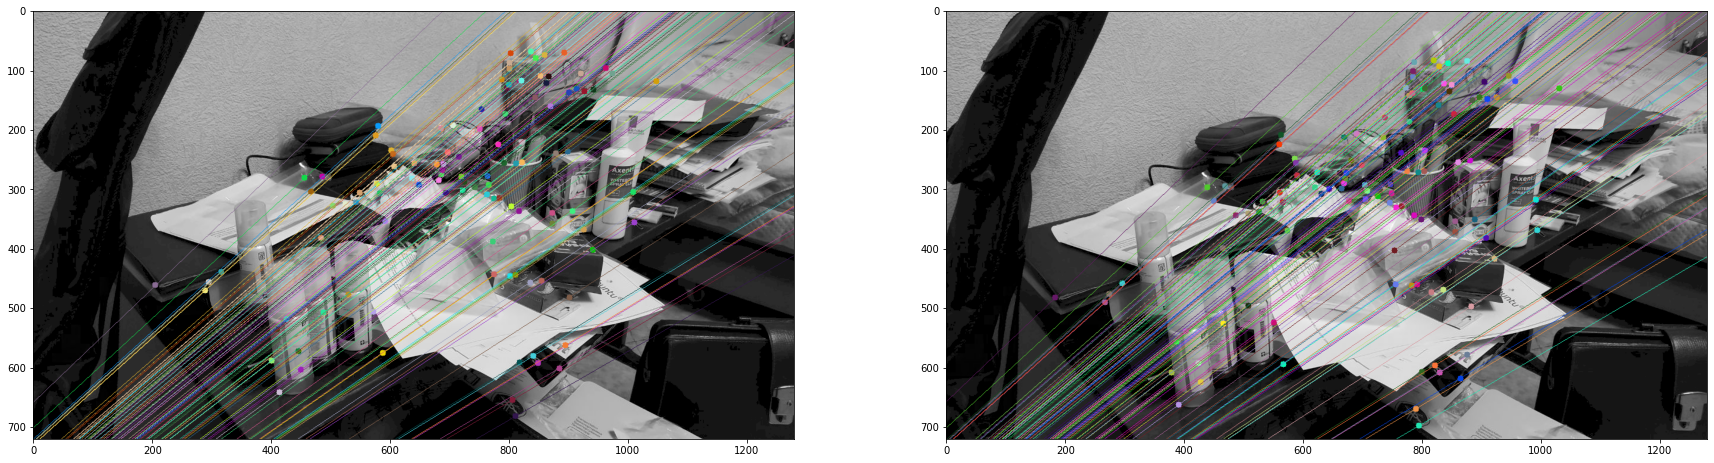

In [12]:
pts1 = src_pts_vis[mask.ravel()==1]
pts2 = dst_pts_vis[mask.ravel()==1]


lines1 = computeEpilines(pts2, 2,F_best)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = computeEpilines(pts1, 1,F_best)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(30,30))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [13]:
plt.imsave('out_left.png',img5)
plt.imsave('out_right.png',img3)